# Package Imports #

In [2]:
# Import the necessary packages

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as mpgs
import glob
%matplotlib inline

# Helper Functions #

In [3]:
# Helper function to merge two lists of images, alternating between both lists
# This is required to display images for comparison

def merge_lists(imgarray1, imgarray2, count=None):
    
    if count is None:
        count = len(imgarray1)
    output = []
    for i in range(count):
        output.append(imgarray1[i])
        output.append(imgarray2[i])
    
    return output

In [4]:
# Helper function to display images
# The input array should contain an even number of images

def display_images(imgarray, titles=None, cmap=None):
    ncols = 2
    nrows = int(len(imgarray)/2)
    figsize = (ncols*9, nrows*7)
        
    fig = plt.figure(figsize=figsize)
    gs = mpgs.GridSpec(nrows, ncols)
    gs.update(bottom=0.375)
    for i in range(len(imgarray)):
        sub = plt.subplot(gs[i])
        if titles is not None:
            sub.set_title(titles[i], size=17)
        sub.imshow(imgarray[i], cmap=cmap)

In [5]:
# Helper function to calibrate the camera

def calibrate_camera(chess_images):
       
    objpoints = []
    imgpoints = []
    
    # Initialize grid points to feed to objpoints
    objpoints_base = np.zeros((rows*cols, 3), np.float32)
    objpoints_base[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) 

    for img in chess_images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (cols, rows))
        
        if(ret):
            # Append points and actual co-ordinates
            objpoints.append(objpoints_base)
            imgpoints.append(corners)
    
    print("\nCalibrating the camera using {} of {} chessboard images".format(len(imgpoints), len(chess_images)))
    
    # Calibrate the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
       
    # Return the camera matrix and distortion coefficients
    return mtx, dist

In [6]:
# Helper function to undistort images

def undistort_images(dist_images, mtx, dist, multi=False):
    
    # For a single image
    if not multi:
        return cv2.undistort(img, mtx, dist)
        
    # Use cv2 to undistort each image
    undistorted_images = np.array([cv2.undistort(img, mtx, dist) for img in dist_images])
    
    return undistorted_images

In [7]:
# Helper function to warp images with a perspective transform

def warp_images(src_images, M, multi=False):
    
    # For a single image
    if not multi:
        return cv2.warpPerspective(src_images, M, src_images.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    # Calculate the image shape
    shape = src_images[0].shape[1::-1]
    
    # Use cv2 to apply the perspective transform on each image
    warped_images = np.array([cv2.warpPerspective(img, M, shape,
                                                  flags=cv2.INTER_LINEAR) for img in src_images])
    
    return warped_images 

# Initial Processing #
Code which uses the helper functions to calibrate the camera. Also demos undistortion.

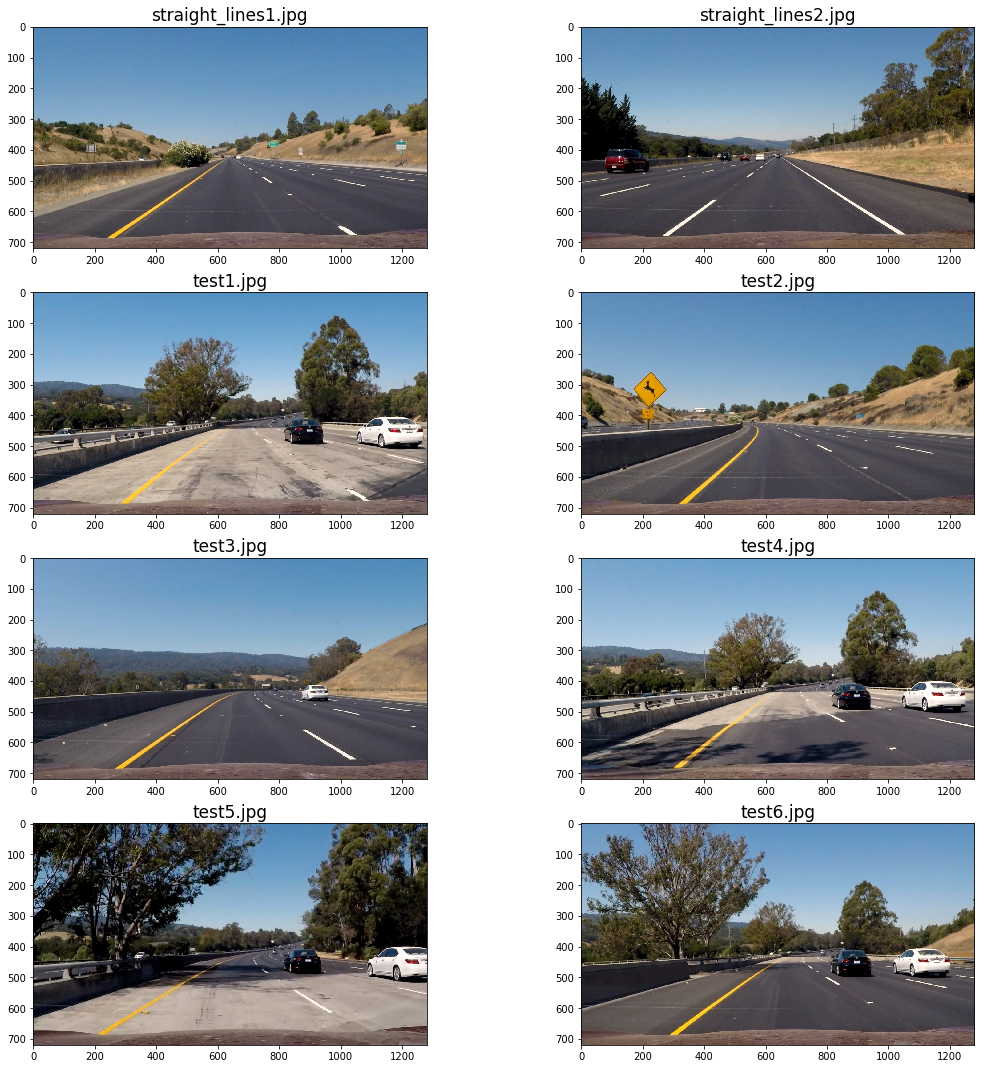

In [9]:
# Read in all the test images

filenames = glob.glob( "test_images\*.jpg")
test_images = np.array([mpimg.imread(name) for name in filenames])

# Display the first four test images
display_images(test_images, titles=[x.split("\\")[-1] for x in filenames])

### Camera Calibration ###

In [10]:
# Read the chessboard images
chess_filenames = glob.glob("camera_cal\calibration*.jpg")
chess_images =  np.array([mpimg.imread(name) for name in chess_filenames])
rows, cols = 6, 9

# Call the helper function to calibrate the camera
mtx, dist = calibrate_camera(chess_images)


Calibrating the camera using 17 of 20 chessboard images


In [11]:
# Call the helper function to undistort the test images
undist_images = undistort_images(chess_images, mtx, dist, multi=True)

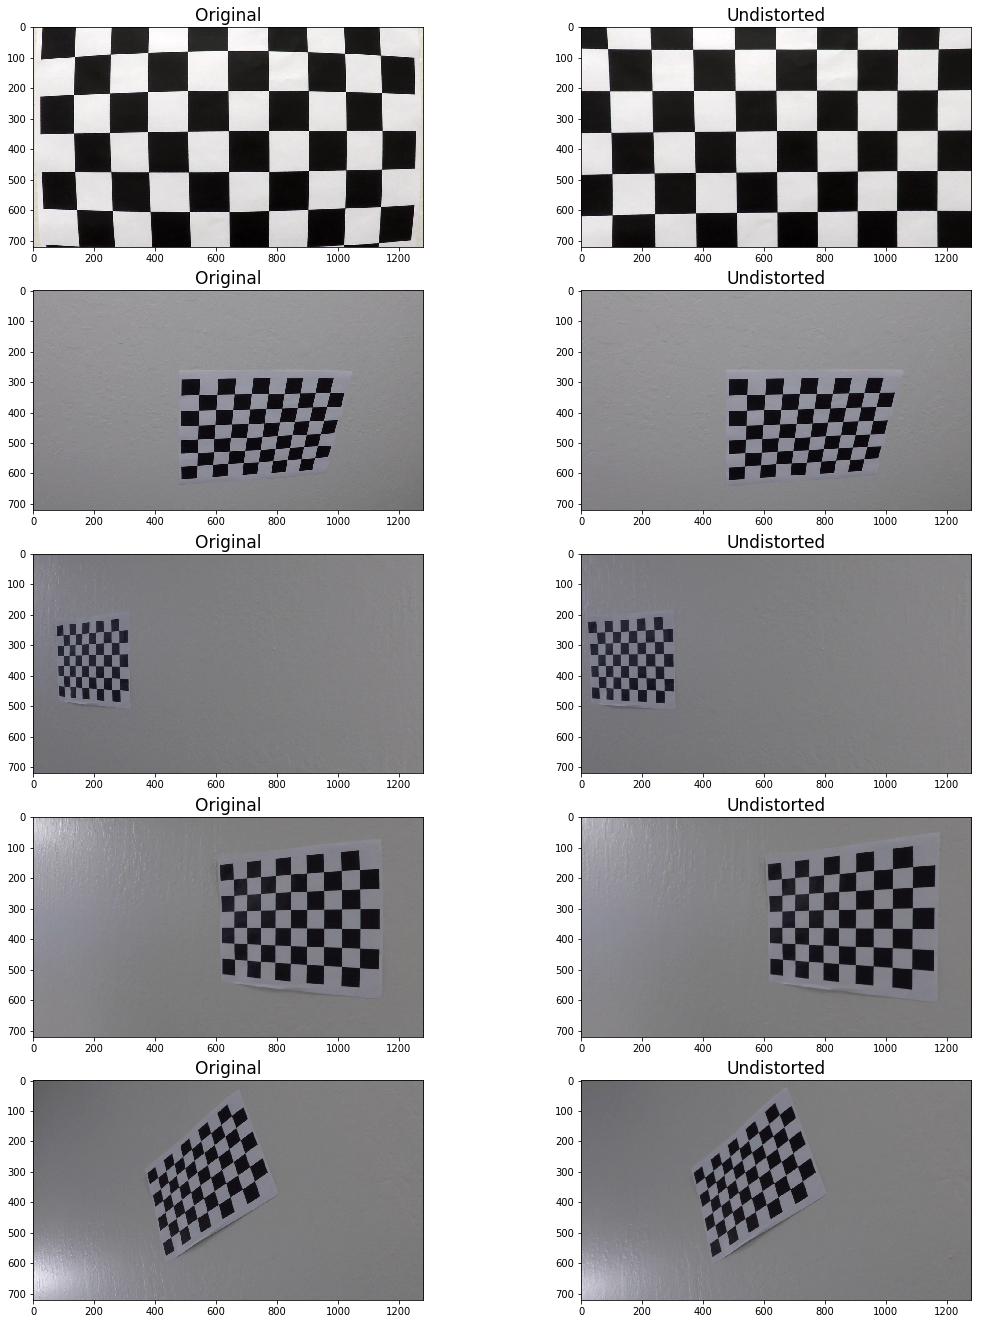

In [12]:
# Display 5 chess board images and their undistorted versions
display_images(merge_lists(chess_images, undist_images, 5 ),
               titles=["Original", "Undistorted"]*5)

### Perspective Transform ###

In [13]:
# Pick an image for defining the perspective transform
source_img = test_images[0]

# Define the source and destination points for the perspective transform
srcTL = [584, 458]
srcTR = [701, 458]
srcBR = [1030, 668]
srcBL = [283, 668]

src = np.float32([srcTL, srcTR, srcBR, srcBL])
dst = np.float32([[375, 0], [900, 0], [900, 720], [375, 720]])
M = cv2.getPerspectiveTransform(src, dst)

warped_img = warp_images(source_img, M)

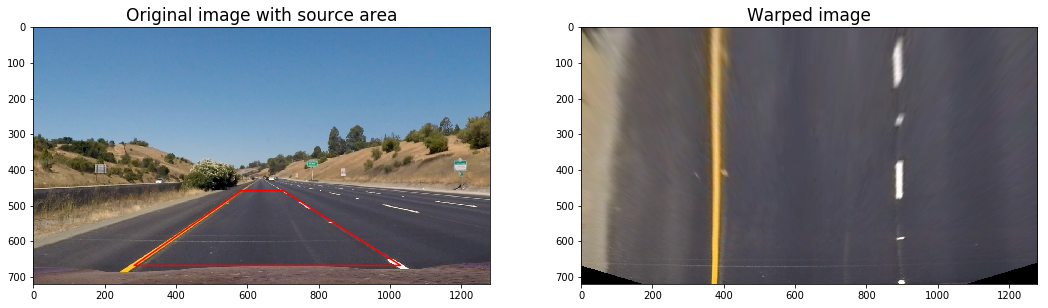

In [14]:
# Compare the original and warped image

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,32))
ax1.imshow(source_img)
ax1.plot([srcTL[0], srcTR[0], srcBR[0], srcBL[0], srcTL[0]],
         [srcTL[1], srcTR[1], srcBR[1], srcBL[1], srcTL[1]], color='red')
ax1.set_title("Original image with source area", size=17)
ax2.imshow(warped_img)
ax2.set_title("Warped image", size=17)

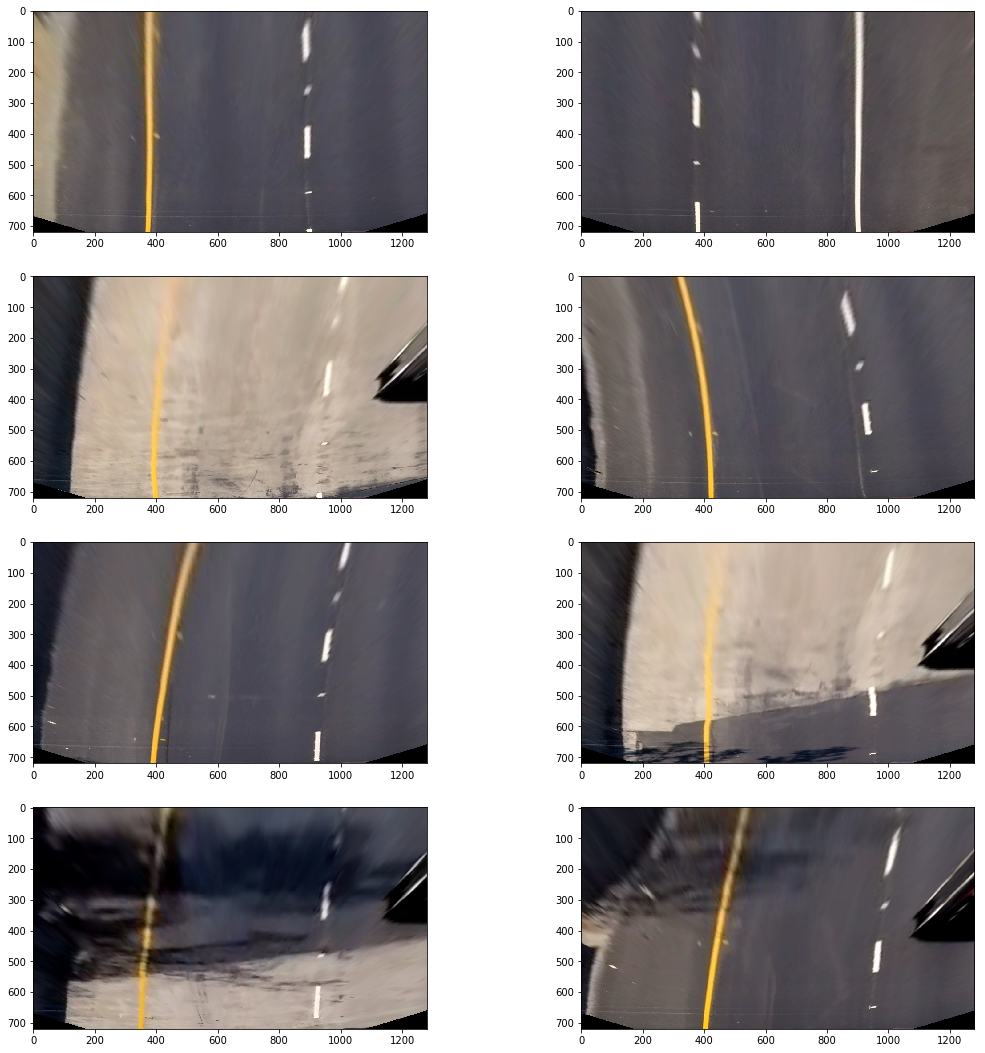

In [15]:
# Warp all test images and display them using the helper functions
display_images(warp_images(test_images, M, multi=True))

### Color Thresholding ###

In [16]:
# Helper function to apply color thresholding

def color_filters(img, s_thresholds=(100,255)):
    
    # Convert to HLS space and isolate the S channel
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls_img[:,:,2]
    
    # Prepare a binary output based on thresholds
    binary_img = np.zeros_like(s_channel)
    binary_img[(s_channel > s_thresholds[0]) & (s_channel <= s_thresholds[1])] = 1
    
    return binary_img

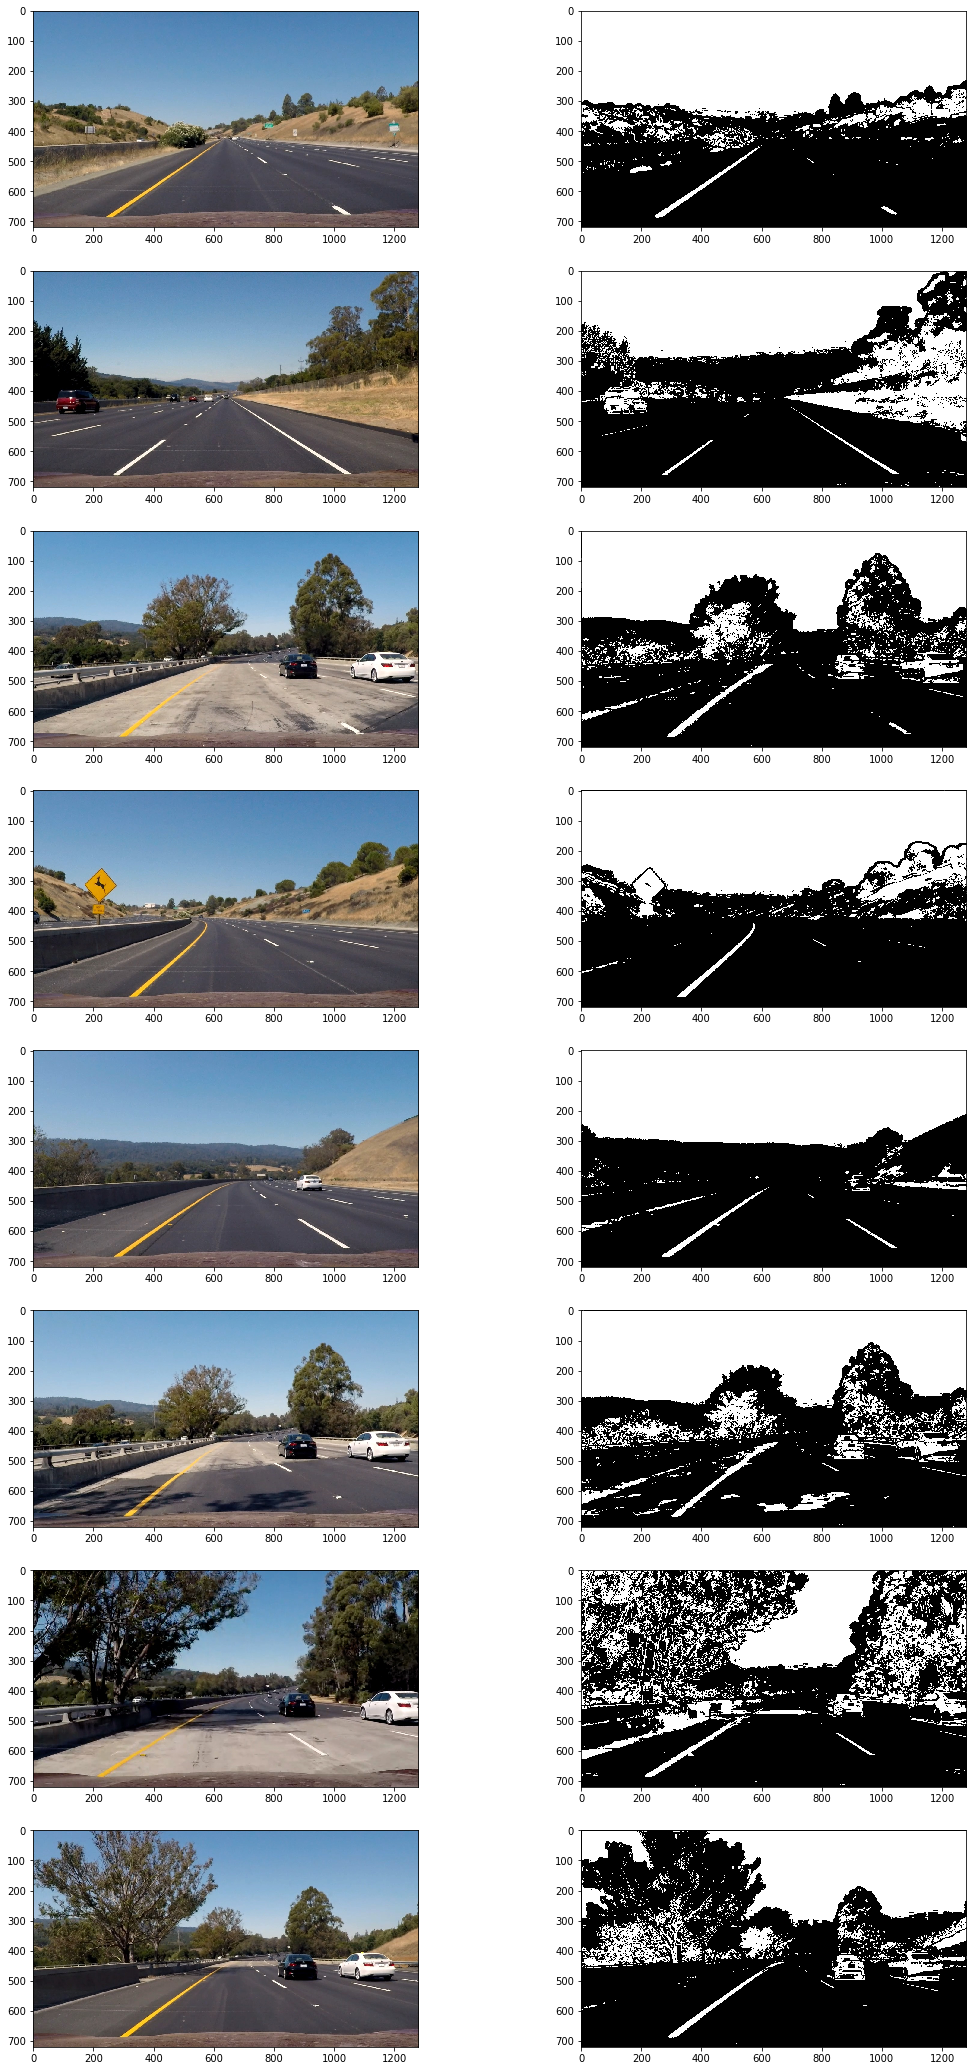

In [17]:
s_images = np.array([color_filters(img, s_thresholds=(80,255)) for img in test_images])
display_images(merge_lists(test_images, s_images), cmap='gray')

### Gradient Thresholding ###

In [32]:
# Helper function that takes a grayscale image and applies gradient thresholds

def gradient_filters(img, sobel_kernel=3, mag_thresholds=(100,200), 
                     dir_thresholds=(0, np.pi/2), x_thresholds=(100,200)):
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate gradients along x and y axes
    x_grad = np.abs(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    y_grad = np.abs(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    abs_x_grad = np.abs(x_grad)
    abs_y_grad = np.abs(y_grad)
    
    scaled_img_x = np.uint(255*abs_x_grad/np.max(abs_x_grad))
    scaled_img_y = np.uint(255*abs_y_grad/np.max(abs_y_grad))
    
    # Calculate the magnitude of the gradients
    mag_grad = np.sqrt(x_grad**2 + y_grad**2)
    mag_grad = np.uint8(255 * mag_grad / np.max(mag_grad))
    
    # Caculdate gradient angle
    dir_angle = np.arctan2(y_grad, x_grad)
    # Combine thresholds
    binary_output = np.zeros_like(scaled_img_x)
    binary_output[\
                #(mag_grad > mag_thresholds[0]) & (mag_grad <= mag_thresholds[1]) &\
                 (scaled_img_x > x_thresholds[0]) & (scaled_img_x <= x_thresholds[1]) &\
                  (dir_angle > dir_thresholds[0]) & (dir_angle <= dir_thresholds[1])\
                 ] = 1
    
    return binary_output

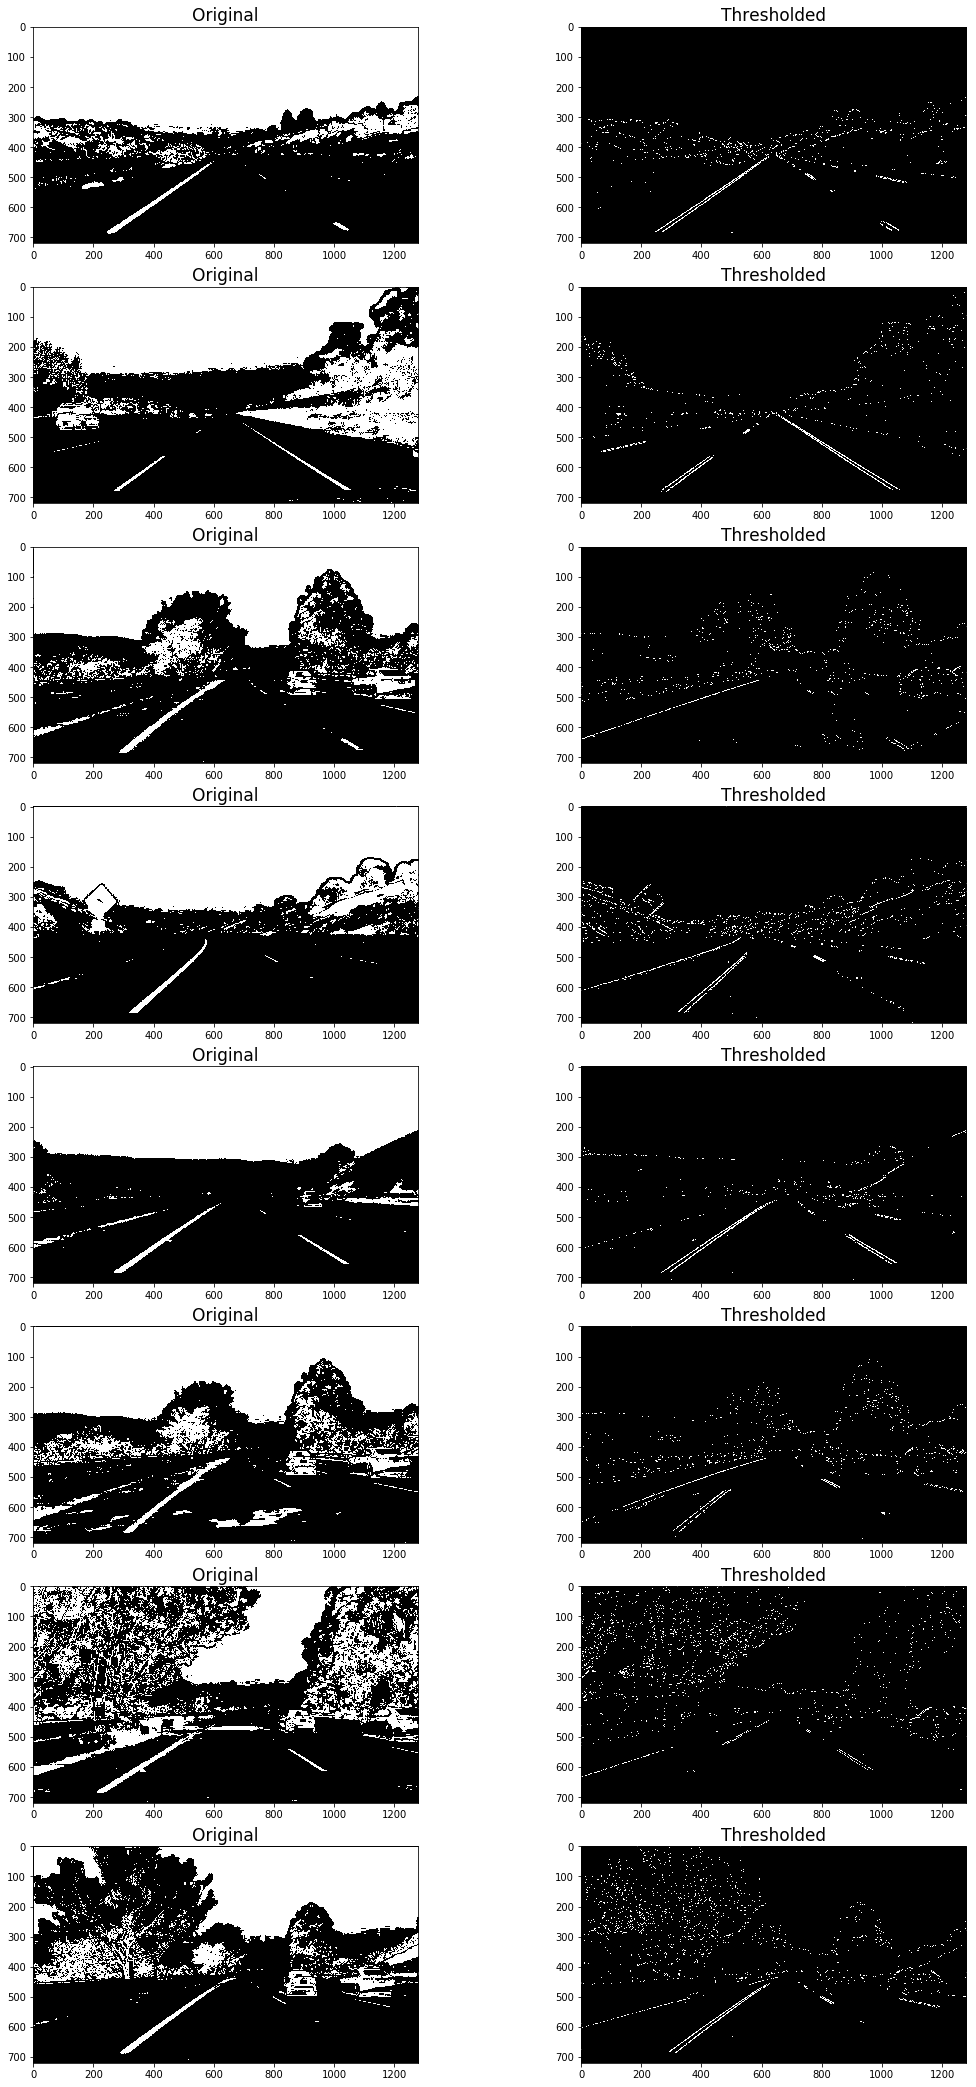

In [37]:
grad_images = np.array([gradient_filters(img, sobel_kernel=5,
                                         mag_thresholds=(1,255),
                                        x_thresholds=(25,255),
                                        dir_thresholds=(np.pi*45/180, np.pi*80/180)
                                        ) for img in test_images])

display_images(merge_lists(s_images, grad_images), titles=["Original", "Thresholded"]*len(test_images), cmap='gray')